In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from src.tsa.ts_utils import *
from src.text.utils import *
from statsmodels.tsa.api import VAR

In [2]:
folderpath = os.getcwd() + "/data/text/solomon_islands/"
nlp = spacy.load("en_core_web_sm")

def process_data(filename, folderpath=folderpath):
    df = pd.read_csv(folderpath + filename).drop("Unnamed: 0", axis=1)
    df["news"] = df["news"].replace("\n", "")
    df["date"] = pd.to_datetime(df["date"])
    df["ym"] = [str(d.year) + "-" + str(d.month) for d in df.date]
    return df


def get_news_count(data: pd.DataFrame, column: str):
    count_df = (data.set_index("date").groupby("ym")[[
        str(column)
    ]].count().reset_index().rename({str(column): str(column) + "_count"},
                                    axis=1))
    return count_df


def get_epu_zscore(data: pd.DataFrame, 
                   cutoff_index: int,
                   epu_col: str = "epu_count",
                   news_col: str = "news_count") -> pd.Series:
    ratio = data[epu_col] / data[news_col]
    ratio_t1 = ratio[:cutoff_index]
    mean, std = ratio_t1.mean(), ratio_t1.std()
    z_score = abs(ratio - mean) / std
    return z_score

In [3]:
ss = process_data("solomon_stars_news.csv")
st = process_data("solomon_times_news.csv")
tis = process_data("island_sun_news.csv")
sibc = process_data("sibc_news.csv")

In [4]:
def extract_entities(corpus: str):
    doc = nlp(corpus)
    ner_dict = {"LOC": "", "ORG": "", "GPE": "", "WORK_OF_ART": ""}
    for e in doc.ents:
        if e.label_ in ner_dict.keys() and e.text not in ner_dict[e.label_]:
            ner_dict[e.label_] += e.text + ", "

    for key, val in ner_dict.items():
        if val.endswith(", "):
            ner_dict[key] = val[:-2]
    return ner_dict

In [ ]:
from tqdm import tqdm
for data, name in zip([st], ["solomon_times_ner"]):
    output = []
    with tqdm(total=len(data)) as pbar:
        for news in data["news"]:
            if type(news) == str:
                ner_dict = extract_entities(news)
            else:
                ner_dict = {
                    "LOC": "Missing",
                    "ORG": "Missing",
                    "GPE": "Missing",
                    "WORK_OF_ART": "Missing"
                }
            output.append(ner_dict)
            pbar.update(1)
    ner_df = pd.DataFrame(output)
    data = pd.concat([data, output], axis=1)
#     data.to_csv(folderpath+name+".csv", encoding="utf-8")

In [24]:
econ_lst = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "financial", "industry", "food"
]

uncertain_lst = [
    "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risky", "not certain", "non-reliable"
]

policy_lst = [
    "government", "governmental", "authorities", "minister", "ministry",
    "parliament", "parliamentary", "tax", "regulation", "legislation",
    "central bank", "cbsi", "imf", "world bank", "international monetary fund",
    "debt"
]

solomon_lst = [
    "solomon", "solomon islands", "honiara", "central province", "tulagi",
    "choiseul", "taro", "guadalcanal", "isabel province", "buala",
    "malaita", "auki", "kirakira", "makira-ulawa", "makira ulawa",
    "rennell and bellona", "tigoa", "temotu", "lata", "western province",
    "gizo"
]

In [5]:
mindate = min(st.date.min(), ss.date.min(), tis.date.min())
maxdate = max(st.date.max(), st.date.max(),  tis.date.max())
start = str(mindate.year) + "-" + str(mindate.month)
end = str(maxdate.year) + "-" + str(maxdate.month)

In [46]:
policy_lst = [
    'employment', 'job', 'workforce', 'labor', 'occupation', 'career',
    'hiring', 'unemployment', 'employment rate', 'job market', 'labor force',
    'job creation', 'job loss', 'wage', 'salary', 'income', 'compensation',
    'benefits', 'promotion', 'retirement', 'termination', 'layoff',
    'redundancy', 'resignation', 'job satisfaction', 'labor market',
    'part-time', 'full-time', 'temporary work', 'permanent employment',
    'freelance', 'self-employment', 'underemployment', 'skill set',
    'human capital', 'workplace', 'employment contract', 'labor union',
    'equal opportunity', 'discrimination', 'labor laws', 'labor rights',
    'wage growth', 'income inequality', 'labor shortage', 'job training',
    'job prospects', 'job turnover', 'job search'
]

stats = pd.DataFrame(pd.date_range(start, end, freq="MS"), columns=["date"])
for npa, np_name in zip([st, ss, tis, sibc], ["st", "ss", "tis", "sibc"]):
    np_count = get_news_count(npa, "news")
    for (category, term_lst) in zip(["econ", "uncertain", "policy"],
                                    [econ_lst, uncertain_lst, policy_lst]):
        npa[str(category)] = npa["news"].apply(is_in_word_list,
                                             terms=term_lst)
    npa["epu"] = (npa.econ == True) & (npa.uncertain == True) & (npa.policy
                                                              == True)
    np_epu_count = get_news_count(npa[npa.epu == True], column="epu")
    np_stat = np_count.merge(np_epu_count, how="left").fillna(0)
    np_stat["date"] = pd.to_datetime(np_stat["ym"])
    np_stat["ratio"] = np_stat["epu_count"] / np_stat["news_count"]
    mean, std = np_stat[np_stat.date < "2020-01-01"]["ratio"].mean(), np_stat[
        np_stat.date < "2020-01-01"]["ratio"].std()
    np_stat["z_score"] = abs(np_stat["ratio"] - mean)/(std)
    
    np_stat.columns = [
        str(np_name) + "_" + str(col) if col != "date" and col != "ym" else col
        for col in np_stat.columns
    ]
    stats = (stats.merge(np_stat, how="left",
                         on="date")).drop("ym", axis=1).fillna(0)

select_cols = [col for col in stats.columns if "z_score" in col]
scaling_factor = 100 / (stats[stats.date < "2020-01-01"][select_cols].mean(
    axis=1).mean())
stats["z_score"] = stats[select_cols].mean(axis=1)
stats["epu_index"] = stats["z_score"] * scaling_factor

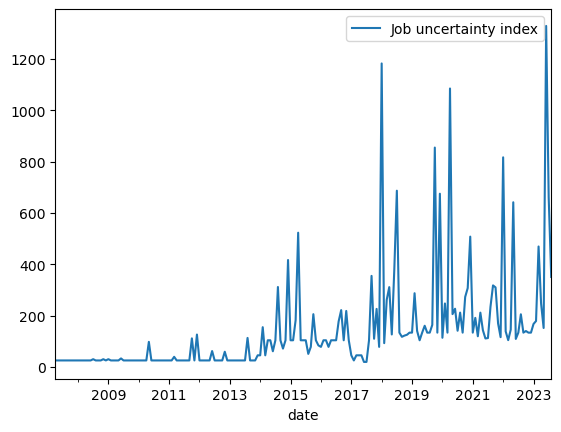

In [47]:
stats.plot(x="date", y="epu_index", label="Job uncertainty index");

## EPU -> Macroeconomic

In [27]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.0,
    103.8, 104.1, 104.2, 104.5, 103.8, 105.1, 104.2, 104.2, 104.3, 105.0,
    108.0, 105.5, 106.6, 106.9, 106.9, 112.4, 112.7, 112.7, 112.2, 111.1,
    107.2, 105.8, 105.1, 105.4, 105.2, 105.3, 104.1, 106.7, 110.6, 112.4,
    109.8, 109.2, 106.6, 106.1, 106.6, 107.3, 107.5, 107.4, 107.8, 108.8,
    109.4, 109.4, 111.5, 113.9, 114.1, 115.4, 117.1, 118.0, 117.8, 117.2,
    117.0, 118.9, 119.2, 119.8
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-03", freq="MS"),
                          columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(stats[["date", "epu_index"]], how="left", on="date")
si_infl["inflation"] = (si_infl["cpi"].diff() / si_infl["cpi"].shift(1)) * 100
si_infl["epu_change"] = (si_infl["epu_index"].diff() /
                         si_infl["epu_index"].shift(1)) * 100

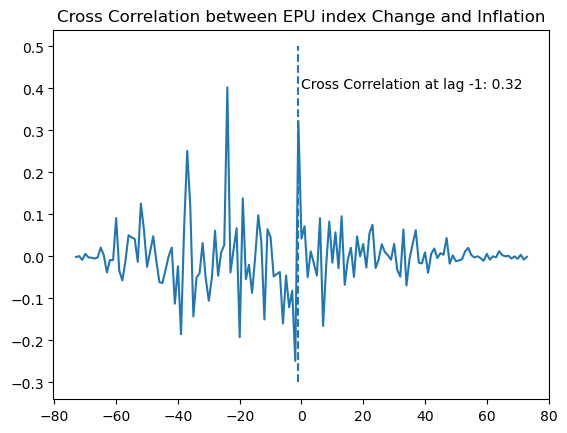

In [28]:
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - p.mean()) / (p.std() * len(p))
    q = (q - q.mean()) / (q.std())
    c = np.correlate(p, q, 'full')
    return c


corr = ccf_values(si_infl["epu_change"][1:], si_infl["inflation"][1:])
lags = signal.correlation_lags(len(si_infl["inflation"][1:]),
                               len(si_infl["epu_index"][1:]))
plt.plot(lags, corr);
plt.vlines(-1, ymin=-0.3, ymax=0.5, linestyle="dashed")
plt.text(0, 0.4, "Cross Correlation at lag -1: 0.32")
plt.title("Cross Correlation between EPU index Change and Inflation");

In [29]:
ccf_df = pd.DataFrame([lags, corr], index=["lags", "ccf"]).T
ccf_df[(ccf_df.lags >= -3) & (ccf_df.lags <= 6)]

,lags,ccf
70,-3.0,-0.081613
71,-2.0,-0.248710
72,-1.0,0.322251
73,0.0,0.042709
74,1.0,0.071977
75,2.0,-0.049230
76,3.0,0.012138
77,4.0,-0.015902
78,5.0,-0.045191
79,6.0,0.091207


In [30]:
var_df = si_infl[["inflation", "epu_index"]][1:].reset_index(drop=True)
print(adf_test(var_df["epu_index"]), "\n", adf_test(var_df["inflation"]))

Test Statistic                -9.328462e+00
p-value                        9.469418e-16
# Lags Used                    0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64 
 Test Statistic                -6.971426e+00
p-value                        8.644916e-10
# Lags Used                    0.000000e+00
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64


In [31]:
def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]

    def adjust(val, length=6):
        return str(val).ljust(length)

    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--' * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">",
              adjust(cvt, 8), ' =>  ', trace > cvt)


cointegration_test(si_infl[["inflation", "epu_index"]].iloc[
    1:,
])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
inflation ::  15.31     > 12.3212   =>   True
epu_index ::  0.98      > 4.1296    =>   False


In [32]:
length = len(si_infl.iloc[1:])
train = int(length * 0.9)
test = length - train


model = VAR(endog=var_df[:train+1])

eval_lst = []
for i in range(0, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,0,11.524999,11.590811,101215.126477,11.551041
1,1,11.485978,11.685038,97353.472866,11.564636
2,2,11.506701,11.841223,99440.072821,11.638691
3,3,11.616109,12.088365,111064.496753,11.802155
4,4,11.643319,12.255643,114376.906875,11.884149
5,5,11.772486,12.527275,130623.712895,12.068835
6,6,11.868507,12.768224,144607.188315,12.221115
7,7,11.929619,12.976791,155013.956018,12.339226
8,8,12.070968,13.268193,180692.673104,12.538316
9,9,12.174804,13.524749,203810.667075,12.700635


In [33]:
best_mod = model.fit(1)
best_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Sep, 2023
Time:                     19:03:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.6850
Nobs:                     66.0000    HQIC:                   11.5646
Log likelihood:          -560.337    FPE:                    97353.5
AIC:                      11.4860    Det(Omega_mle):         89072.0
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.261640         0.228377           -1.146           0.252
L1.inflation         0.185974         0.116940            1.590           0.112
L1.epu_index         0.001919         0.000662            2.

In [34]:
si_infl["epu_change_1"] = si_infl["epu_change"].shift(1)
si_infl["epu_change_2"] = si_infl["epu_change"].shift(2)
si_infl

,date,cpi,epu_index,inflation,epu_change,epu_change_1,epu_change_2
0,2017-01-01,98.6,55.984630,NaN,NaN,NaN,NaN
1,2017-02-01,99.0,26.801396,0.405680,-52.127224,NaN,NaN
2,2017-03-01,100.6,55.984630,1.616162,108.886989,-52.127224,NaN
3,2017-04-01,100.7,55.984630,0.099404,0.000000,108.886989,-52.127224
4,2017-05-01,101.0,55.984630,0.297915,0.000000,0.000000,108.886989
...,...,...,...,...,...,...,...
70,2022-11-01,117.2,150.344874,-0.509338,-24.896478,3.873406,-33.134189
71,2022-12-01,117.0,150.344874,-0.170648,0.000000,-24.896478,3.873406
72,2023-01-01,118.9,133.671595,1.623932,-11.090021,0.000000,-24.896478
73,2023-02-01,119.2,264.915339,0.252313,98.183719,-11.090021,0.000000


In [36]:
import statsmodels.formula.api as smf
ols_mod = smf.ols("inflation~epu_change_1", data=si_infl[:train+1])
ols_res = ols_mod.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     7.763
Date:                Wed, 20 Sep 2023   Prob (F-statistic):            0.00704
Time:                        19:04:01   Log-Likelihood:                -107.38
No. Observations:                  65   AIC:                             218.8
Df Residuals:                      63   BIC:                             223.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1210      0.165      0.733      0.466      -0.209       0.451
epu_change_1     0.0022      0.001      2.786      0.007       0.001       0.004
==============================================================================
Omnibus:                        4.525   Durbin-Watson:                   1.471
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.831
Skew:                           0.225   Prob(JB):                       0.0893
Kurtosis:                       4.257   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
ols_predict = ols_res.fittedvalues
ols_forecast = ols_res.predict(si_infl["epu_change_1"][-test:])
ols_all = pd.concat([ols_predict, ols_forecast], axis=0)

In [38]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(best_mod.resid)
out

array([1.79888306, 1.99913327])

In [39]:
var_forecast = best_mod.forecast(y=var_df.values[-test:], steps=test)
var_forecast_df = pd.DataFrame(var_forecast, index=var_df.index[-test:], columns=["var_inflation", "var_epu"])

In [40]:
var_df["date"] = pd.date_range(start="2017-01", periods=len(var_df), freq="MS")
fit_df = best_mod.fittedvalues.rename({"epu_index": "var_epu_index",
                                       "inflation": "var_inflation"}, axis=1)
fit_df = pd.concat([fit_df, var_df[1:train+1]], axis=1).reset_index(drop=True)

In [42]:
fit_df

,var_inflation,var_epu_index,inflation,epu_index,date
0,-0.134761,276.145321,1.616162,55.984630,2017-02-01
1,0.146362,268.070843,0.099404,55.984630,2017-03-01
2,-0.135716,274.394538,0.297915,55.984630,2017-04-01
3,-0.098798,273.566902,-0.396040,29.183234,2017-05-01
4,-0.279289,279.240751,-0.099404,29.183234,2017-06-01
...,...,...,...,...,...
61,0.203241,255.484696,1.919561,222.569626,2022-03-01
62,0.522471,249.522975,2.152466,233.500567,2022-04-01
63,0.586762,247.417875,0.175593,127.634493,2022-05-01
64,0.015953,266.643330,1.139351,251.287890,2022-06-01


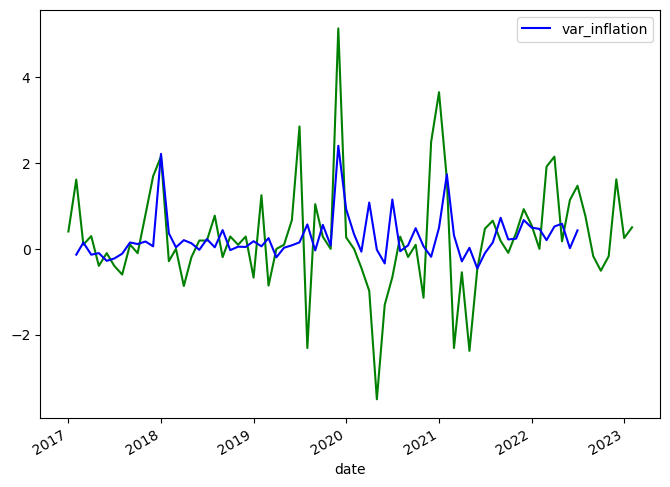

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(var_df["date"].values, var_df["inflation"].values, color="green")
fit_df.plot(x="date", y="var_inflation", ax=ax, color="blue")
# ax.plot(var_df["date"][1:].values, ols_all.values)
# ax.plot(var_forecast_df["var_inflation"].index.values,
#         var_forecast_df["var_inflation"].values,
#         label="var_predict_test", color="blue")
# ax.plot(ols_all, color="orange")
plt.show();

## EPU

In [45]:
stats[stats.epu_index == stats.epu_index.max()]

,date,st_news_count,st_epu_count,st_ratio,st_z_score,ss_news_count,ss_epu_count,ss_ratio,ss_z_score,tis_news_count,tis_epu_count,tis_ratio,tis_z_score,sibc_news_count,sibc_epu_count,sibc_ratio,sibc_z_score,z_score,epu_index
152,2019-12-01,54.0,2.0,0.037037,1.689495,118.0,0.0,0.0,0.601666,6.0,1.0,0.166667,4.713724,25.0,2.0,0.08,6.835686,3.460143,1389.551717


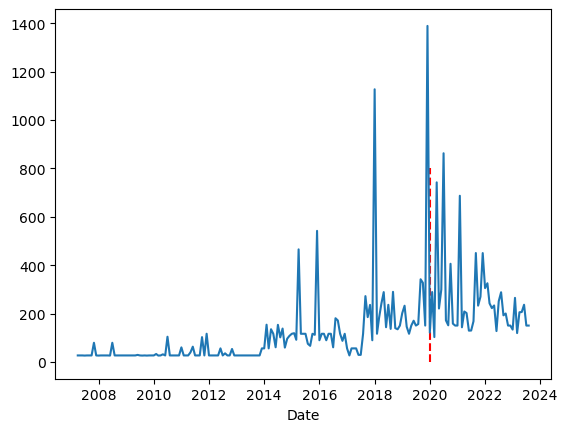

In [43]:
plt.plot(stats["date"].values, stats["epu_index"].values, label="EPU Index")
plt.xlabel("Date")
plt.vlines(x=pd.to_datetime("2020-01-01"), ymin=0, ymax=800, color="red", linestyle="dashed")
# plt.hlines(y=100, xmin=pd.to_datetime("2007-01"), xmax=pd.to_datetime("2024-01"), color="green", linestyle="dashed")
plt.show()

In [ ]:
np_names = ["st", "ss", "tis", "sibc"]
news_col = [col + "_news_count" for col in np_names]
stats["news_count"] = stats[news_col].sum(axis=1)
for nc, name in zip(news_col, np_names):
    stats[str(name) + '_ratio'] = stats[nc]/stats["news_count"]

In [ ]:
stats[stats.adj_epu_index >= np.percentile(stats.adj_epu_index, 95)]

In [ ]:
adj_ratio_lst = []
for idx in stats.index:
    adj_ratio = 0
    for news in np_names:
        zscore_col = news + "_z_score"
        ratio_col = news + "_ratio"
        adj_ratio += stats[zscore_col][idx] * stats[ratio_col][idx]
    adj_ratio_lst.append(adj_ratio)
    
stats["adj_z_score"] = adj_ratio_lst

In [ ]:
scaling_factor = 100/(stats[stats.date >= "2020-01-01"]["adj_z_score"].mean())
stats["adj_epu_index"] = stats["adj_z_score"] * scaling_factor
stats.plot(x="date", y="adj_epu_index");

In [ ]:
stats_alt = stats.copy()
stats_alt["news_count"] = stats_alt[["st_news_count", "ss_news_count", "tis_news_count", "sibc_news_count"]].mean(axis=1)
stats_alt["epu_count"] = stats_alt[["st_epu_count", "ss_epu_count", "tis_epu_count", "sibc_epu_count"]].mean(axis=1)
cutoff_index = stats_alt[stats_alt.date == pd.to_datetime("2019-12-01")].index[0] + 1
stats_alt["z_score_alt"] = get_epu_zscore(stats_alt, cutoff_index=cutoff_index)
sf_alt = 100/(stats_alt["z_score_alt"][cutoff_index:].mean())
stats_alt["epu_alt"] = sf_alt * stats_alt["z_score_alt"]
stats_alt.plot(x="date", y="epu_alt");